# PROJECT: AMAZON REVIEW SENTIMENT ANALYSIS 
- Data: crawled using a tool developed by VI PHAM
- Source: https://github.com/anhvi02/AmazonReview_Crawl_NLP.git

In [510]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# NN
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Conv1D, GlobalAveragePooling1D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from tensorflow import keras 
from keras.preprocessing import sequence

# Data

In [511]:
df = pd.read_csv('AmazonData.csv')
df.head()

,Name,Star,Location,Date,Category,Title,Review
0,carla w.,1.0,the United States 🇺🇸,23-Mar-22,Girl Clothing,Missing,I only received 6 pair not 12 the photo shows ...
1,mamma3,1.0,the United States 🇺🇸,22-Jan-13,Girl Clothing,Hane's Red Label Crew socks,I really don't like to write bad reviews but t...
2,DinaZ,1.0,the United States 🇺🇸,3-Jul-13,Girl Clothing,No shape to these socks,They were actually very funny as the shape was...
3,bronx girl,1.0,the United States 🇺🇸,7-Jul-14,Girl Clothing,tears quickly,These sock tore at the top area quickly. I wou...
4,Summer,2.0,the United States 🇺🇸,6-Jul-22,Girl Clothing,Terrible,These feel like polyester and washed terribly....


In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      16098 non-null  object 
 1   Star      18467 non-null  float64
 2   Location  18421 non-null  object 
 3   Date      18454 non-null  object 
 4   Category  18484 non-null  object 
 5   Title     18109 non-null  object 
 6   Review    18424 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1011.0+ KB


# Preprocessing:
 - missing values
 - duplicates
 - text handling: lowercase, lemmatize,...
 - remove outliers
 - label

Missing value

In [513]:
df.isnull().sum()

Name        2386
Star          17
Location      63
Date          30
Category       0
Title        375
Review        60
dtype: int64

In [514]:
df = df.dropna(subset=['Review'])
values = {'Name':'Unknown','Location':'Unknown','Title':'Unknown'}
df = df.fillna(value=values)
df.isnull().sum()

Name        0
Star        0
Location    0
Date        0
Category    0
Title       0
Review      0
dtype: int64

Duplicates

In [515]:
df = df.drop_duplicates(subset='Review')
df.shape

(12703, 7)

Drop reviews not from an English speaking country

In [516]:
df = df[df['Location'].str.contains('the|Canada')]
df.shape

(12558, 7)

#### NLP TEXT PREPROCESSING:
- Lowercase
- Remove icon/emoji/symbols
- Remove punctuations
- Remove stop words
- Lemmatize
- Tokenize

Example with a record in the dataset

In [517]:
txt = df['Review'][30]
print('-- Original text: ', len(txt.split(' ')),'words')
print(txt,'\n')

# lowercase
txt = txt.lower()
print('-- Lowercase: ', len(txt.split(' ')),'words')
print(txt,'\n')

# remove punc
from gensim.parsing.preprocessing import strip_punctuation
txt = strip_punctuation(txt)
print('-- Remove punctuations: ', len(txt.split(' ')),'words')
print(txt,'\n')

# remove stop words
from gensim.parsing.preprocessing import remove_stopwords
txt = remove_stopwords(txt)
print('-- Remove stop words: ', len(txt.split(' ')),'words')
print(txt,'\n')

# lemmatize

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    token = sentence.split(' ')
    lem_list = ''
    for word in token:
        lem_list += lemmatizer.lemmatize(word) + ' '
    return lem_list
txt = lemmatize(txt)
print('-- Lemmatize: ', len(txt.split(' ')),'words')
print(txt, '\n')

# tokenize

import spacy
nlp = spacy.load('en_core_web_sm')
tokenized = [token.text for token in nlp.tokenizer(txt)]
print('-- Tokenize: ', len(tokenized), 'elements')
print(tokenized)


-- Original text:  109 words
My daughter is 7. I got these for her to wear around the house as play clothes. As she was putting them on for the first time a giant hole ripped in the seam in the butt of the pants!!! Waste of money!!! I was going to order more in different colors but I will go elsewhere! You get what you pay for but she never even got to wear these!!! I will say that she has had other children's place leggings in the past and they lasted her awhile. Idk if they switched to cheaper materials or this was just a fluke or what but I'm so disappointed!! 

-- Lowercase:  109 words
my daughter is 7. i got these for her to wear around the house as play clothes. as she was putting them on for the first time a giant hole ripped in the seam in the butt of the pants!!! waste of money!!! i was going to order more in different colors but i will go elsewhere! you get what you pay for but she never even got to wear these!!! i will say that she has had other children's place leggings in 

Lowercase

In [518]:
df['Review'] = df['Review'].apply(lambda x :x.lower())

Remove symbols and special character

In [519]:
df['Review'] = df['Review'].str.replace('\W', ' ', regex=True)

Remove punctuations

In [520]:
from gensim.parsing.preprocessing import strip_punctuation
df['Review'] = df['Review'].apply(lambda x :strip_punctuation(x))

Remove stop words

In [521]:
from gensim.parsing.preprocessing import remove_stopwords
df['Review'] = df['Review'].apply(lambda x :remove_stopwords(x))

Lemmatize

In [522]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(sentence):
    token = sentence.split(' ')
    lem_list = ''
    for word in token:
        lem_list += lemmatizer.lemmatize(word) + ' '
    return lem_list

df['Review'] = df["Review"].apply(lambda x : lemmatize(x))

Tokenize

In [523]:
df['Review_tokenized'] = df["Review"].apply(lambda x : [token.text for token in nlp.tokenizer(x)])
df.head(3)

,Name,Star,Location,Date,Category,Title,Review,Review_tokenized
0,carla w.,1.0,the United States 🇺🇸,23-Mar-22,Girl Clothing,Missing,i only received 6 pair not 12 the photo shows ...,"[i, only, received, 6, pair, not, 12, the, pho..."
1,mamma3,1.0,the United States 🇺🇸,22-Jan-13,Girl Clothing,Hane's Red Label Crew socks,i really don t like to write bad reviews but t...,"[i, really, don, t, like, to, write, bad, revi..."
2,DinaZ,1.0,the United States 🇺🇸,3-Jul-13,Girl Clothing,No shape to these socks,they were actually very funny as the shape was...,"[they, were, actually, very, funny, as, the, s..."


Get length of text

In [524]:
df['Review_len']  = [len(x) for x in df['Review_tokenized']]
df.head(3)

,Name,Star,Location,Date,Category,Title,Review,Review_tokenized,Review_len
0,carla w.,1.0,the United States 🇺🇸,23-Mar-22,Girl Clothing,Missing,i only received 6 pair not 12 the photo shows ...,"[i, only, received, 6, pair, not, 12, the, pho...",18
1,mamma3,1.0,the United States 🇺🇸,22-Jan-13,Girl Clothing,Hane's Red Label Crew socks,i really don t like to write bad reviews but t...,"[i, really, don, t, like, to, write, bad, revi...",96
2,DinaZ,1.0,the United States 🇺🇸,3-Jul-13,Girl Clothing,No shape to these socks,they were actually very funny as the shape was...,"[they, were, actually, very, funny, as, the, s...",49


In [525]:
df = df.reset_index(drop=True)
print('-- Total of data records:', len(df))

-- Total of data records: 12558


Remove empty records (blank space)

In [526]:
df_empty =df[df['Review'] == ' ']
print('-- Total of empty records:', len(df_empty))
df_empty.head(3)

-- Total of empty records: 2


,Name,Star,Location,Date,Category,Title,Review,Review_tokenized,Review_len
5493,MJ BookReader,4.0,the United States,28-Nov-20,Boy Clothing,🙂,,[ ],1
6337,D N,4.0,the United States,29-Sep-20,Boy Clothing,👍,,[ ],1


In [527]:
df = df.drop(df_empty.index)
df = df.reset_index(drop=True)
print('-- Total of data records after dropping empty records:', len(df))

-- Total of data records after dropping empty records: 12556


Plotting length of reviews

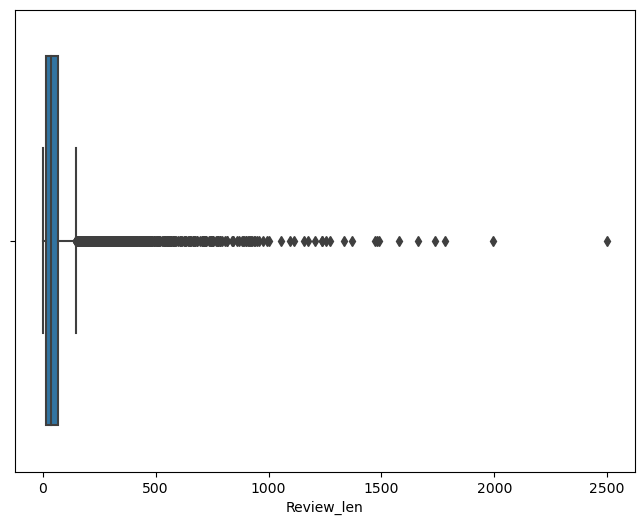

In [528]:
figure = plt.figure(figsize=(8,6))
sns.boxplot(df['Review_len'])
plt.show()

Base on the distribution of review length. I will remove reviews that have more than 150 words and empty: most of data has less than 150 words (only 222 records have above 150 words)

In [529]:
thres_len = 150
count = len(df[df['Review_len'] > thres_len])
print('-- Total of records has more than 150 words:', count)


-- Total of records has more than 150 words: 953


In [530]:
df = df[df['Review_len'] < thres_len]
print('-- Data Shape: ')
df.shape 

-- Data Shape: 


(11595, 9)

Length of reviews distribution after dropping records

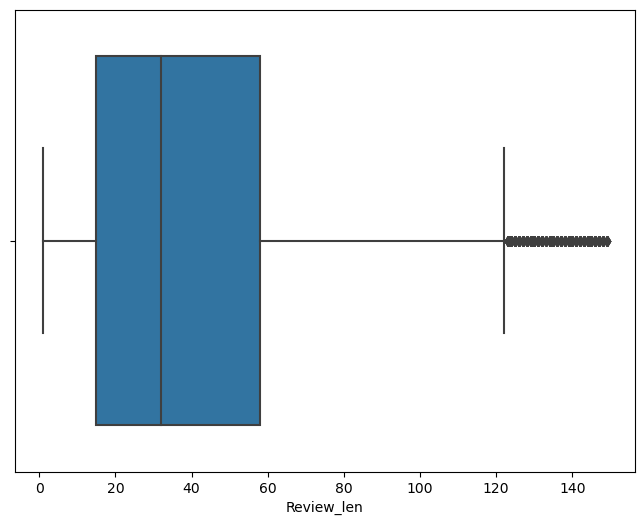

In [531]:
figure = plt.figure(figsize=(8,6))
sns.boxplot(df['Review_len'])
plt.show()

Labeling:
- 1 and 2 stars: Negative (labeled 0)
- 3 stars: Neutral (labeled 1)
- 4 and 5 stars: Positive (labeled 2)

In [532]:
df['label'] = 0
df.loc[df['Star'] ==  3, 'label'] = 1
df.loc[df['Star'] >  3, 'label'] = 2
df.head(3)

,Name,Star,Location,Date,Category,Title,Review,Review_tokenized,Review_len,label
0,carla w.,1.0,the United States 🇺🇸,23-Mar-22,Girl Clothing,Missing,i only received 6 pair not 12 the photo shows ...,"[i, only, received, 6, pair, not, 12, the, pho...",18,0
1,mamma3,1.0,the United States 🇺🇸,22-Jan-13,Girl Clothing,Hane's Red Label Crew socks,i really don t like to write bad reviews but t...,"[i, really, don, t, like, to, write, bad, revi...",96,0
2,DinaZ,1.0,the United States 🇺🇸,3-Jul-13,Girl Clothing,No shape to these socks,they were actually very funny as the shape was...,"[they, were, actually, very, funny, as, the, s...",49,0


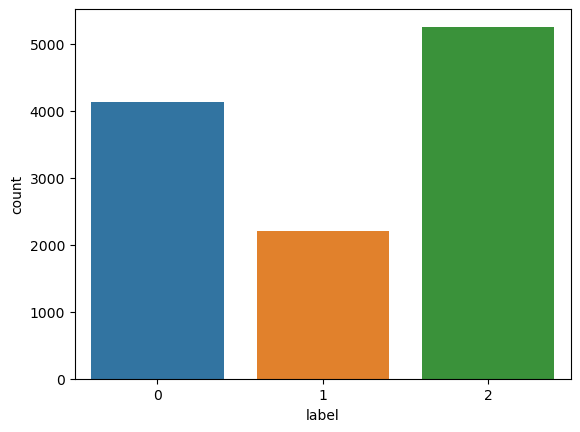

In [533]:
sns.countplot(df['label'])
plt.show()

# TRANSFORM DATA:

One-hot-encode label

In [534]:
x = df['Review']

labels = df['label']
y = to_categorical(labels)

In [535]:
x.shape

(11595,)

In [536]:
y.shape

(11595, 3)

In [537]:
training_size = 11000
valid_size = 1500
x_train_val = x[:training_size]
y_train_val = y[:training_size]

x_val = x_train_val[:valid_size]
y_val = y_train_val[:valid_size]

x_train = x_train_val[valid_size:]
y_train = y_train_val[valid_size:]

x_test  = x[training_size:]
y_test  = y[training_size:]

print('-- Train data: ')
print('x:',x_train.shape)
print('y:',y_train.shape)

print('-- Validation data: ')
print('x:',x_val.shape)
print('y:',y_val.shape)

print('-- Test data: ')
print('x:',x_test.shape)
print('y:',y_test.shape)

-- Train data: 
x: (9500,)
y: (9500, 3)
-- Validation data: 
x: (1500,)
y: (1500, 3)
-- Test data: 
x: (595,)
y: (595, 3)


In [538]:
word_cnt = []
for it in df['Review_tokenized']:
    for word in it:
        if word not in word_cnt:
            word_cnt.append(word)
print('-- Total of vocabularies in dataset: ',len(word_cnt))


-- Total of vocabularies in dataset:  11147


In [539]:
vocab_size = 3000
max_seq = 150
def generate_token(data, max_seq, vocab_size, padding_type = 'post', trunc_type = 'post'):
    tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(data)
    padded = keras.utils.pad_sequences(sequences, maxlen=max_seq, padding=padding_type, truncating=trunc_type)
    return padded

In [540]:
x_train = generate_token(x_train,max_seq,vocab_size)
x_train.shape

(9500, 150)

In [541]:
x_val = generate_token(x_val, max_seq,vocab_size)
x_val.shape

(1500, 150)

In [542]:
x_test = generate_token(x_test,max_seq,vocab_size)
x_test.shape

(595, 150)

# MODELING

In [543]:
vocab_size = 3000
embedding_dim = 16
max_seq = 150
num_filter = 128

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq))

model.add(Conv1D(num_filter,(3),padding='valid', activation='relu'))
model.add(GlobalAveragePooling1D())


model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 150, 16)           48000     
                                                                 
 conv1d_15 (Conv1D)          (None, 148, 128)          6272      
                                                                 
 global_average_pooling1d_19  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 3)                 195       
                                                                 
Total params: 62,723
Trainable params: 62,723
Non-trainable params: 0
_________________________________________________

In [544]:
num_epochs = 5
batch_size = 128
history = model.fit(x_train, y_train, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                    validation_data=(x_val,y_val), 
                    verbose=1)

Epoch 1/5
75/75 [==============================] - 3s 25ms/step - loss: 1.0490 - accuracy: 0.4423 - val_loss: 1.0460 - val_accuracy: 0.4340
Epoch 2/5
75/75 [==============================] - 2s 25ms/step - loss: 1.0085 - accuracy: 0.5043 - val_loss: 1.0467 - val_accuracy: 0.4433
Epoch 3/5
75/75 [==============================] - 2s 24ms/step - loss: 0.8346 - accuracy: 0.6441 - val_loss: 1.1595 - val_accuracy: 0.4467
Epoch 4/5
75/75 [==============================] - 2s 24ms/step - loss: 0.7095 - accuracy: 0.6979 - val_loss: 1.2675 - val_accuracy: 0.4413
Epoch 5/5
75/75 [==============================] - 2s 24ms/step - loss: 0.6617 - accuracy: 0.7177 - val_loss: 1.3400 - val_accuracy: 0.4280


In [545]:
loss, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

5/5 [==============================] - 0s 8ms/step - loss: 1.1686 - accuracy: 0.4891


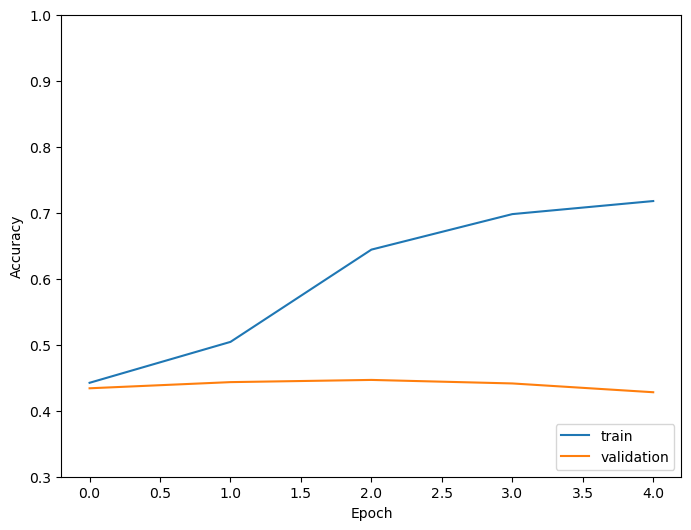

In [546]:
figure = plt.figure(figsize=(8,6))               
plt.plot(history.history['accuracy'], label='train')

plt.plot(history.history['val_accuracy'], label = 'validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

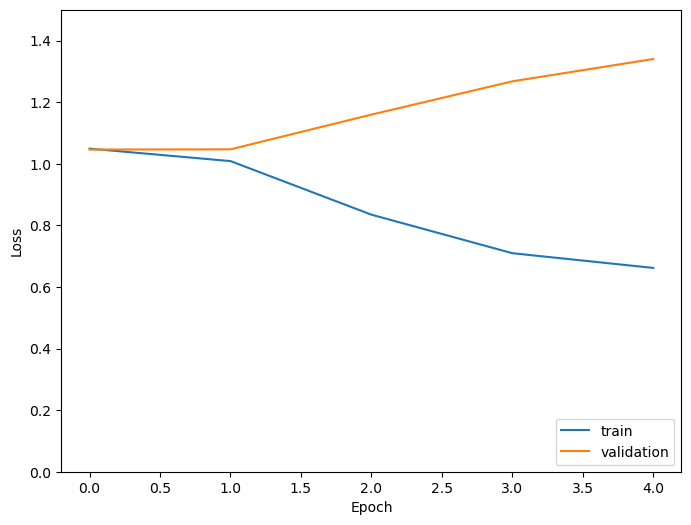

In [547]:
figure = plt.figure(figsize=(8,6))               
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label = 'validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.legend(loc='lower right')
plt.show()